In [110]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
from collections import namedtuple
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import linregress
import imageio

%matplotlib inline

# Optionally, tweak styles.
rc('animation', html='html5')
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import glob
from sxmreader import SXMReader

Params = namedtuple(
    'Params', 
    ['molecule_size', 
     'min_mass',
     'max_mass',
     'separation',
     'min_size',
     'max_ecc',
     'adaptive_stop',
     'search_range'])

sets = [range(246 + 30 * i, 246 + 30 * (i + 1)) for i in range(6)]
voltage = np.arange(4.2, 5.4, 0.2)
params = [
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
     Params(molecule_size=11, min_mass=1.5, max_mass=10, separation=None, min_size=2, max_ecc=1, adaptive_stop=10, search_range=15),
         ]
n_range = [i for i in sets]
N = [len(i) for i in sets]
SXM_PATH = [["electromigration_12/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]

In [111]:
sets

[range(246, 276),
 range(276, 306),
 range(306, 336),
 range(336, 366),
 range(366, 396),
 range(396, 426)]

In [112]:
def is_track_good(track, tol=3e-9):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (tol/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good

Frame 29: 11 trajectories present.


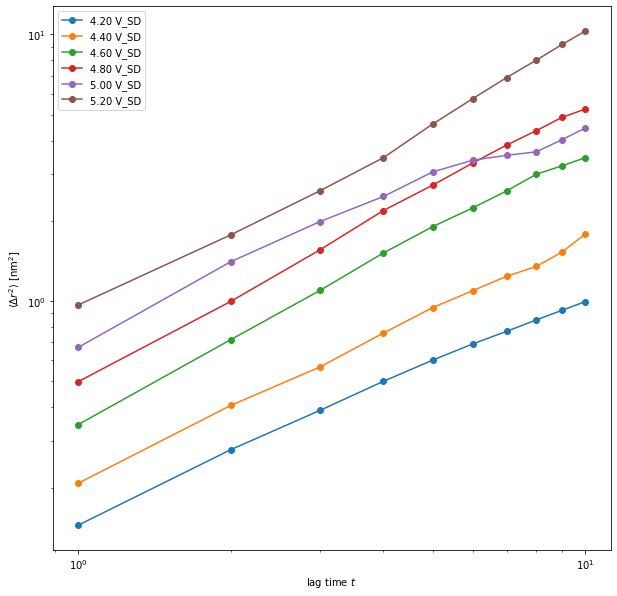

In [113]:
powers = []
D_constants = []
indices = []
ems = []
counts = []
# voltage = np.arange(2.2,4.3,0.3)
fig, ax = plt.subplots(figsize=(10,10))
idx = 0
    
for i, path in enumerate(SXM_PATH):
    frames = SXMReader(path)
    molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range = params[i]
    if separation:
        f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
    else:
        f = tp.batch(frames[:], molecule_size, minmass=min_mass)
    t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop, memory=3)    
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 1)
    d = tp.compute_drift(t2)
    t3 = tp.subtract_drift(t2.copy(), d)
    good_particles = []
    bad_particles = []
    t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
    paths = []
    tm = t4.groupby('particle').filter(is_track_good)
    tm = t3
#     counts.append(f.groupby('frame').size().max())
    im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
#     bl = tp.is_typical(im, 1)
#     tm = tm[tm.particle.isin(bl.index[bl].tolist())]
#     if i == 6:
#         em = tp.emsd(tm, frames.meters_per_pixel*1e9, 1) # microns per pi
#     else:
    em = tp.emsd(tm, frames.meters_per_pixel*1e9, 1, max_lagtime=10) # microns per pixel = 100/285., frames per second = 24
    ax.plot(em.index, em, 'o-', label= "{:.2f} V_SD".format(voltage[idx]))
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
    xlabel='lag time $t$')
    #ax.set(ylim=(1e-2, 10));
#     result = tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
    result, _, _, _, _ = linregress(em.index, em)
    indices.append(em.index)
#     powers.append(result['n'])
#     D_constants.append(result['A'])
    D_constants.append(result)
    idx=idx+1

In [114]:
D_constants

[0.0933061317296135,
 0.16699025749690521,
 0.3542195726544141,
 0.5424322925156443,
 0.38859909493084094,
 1.0549939870868301]

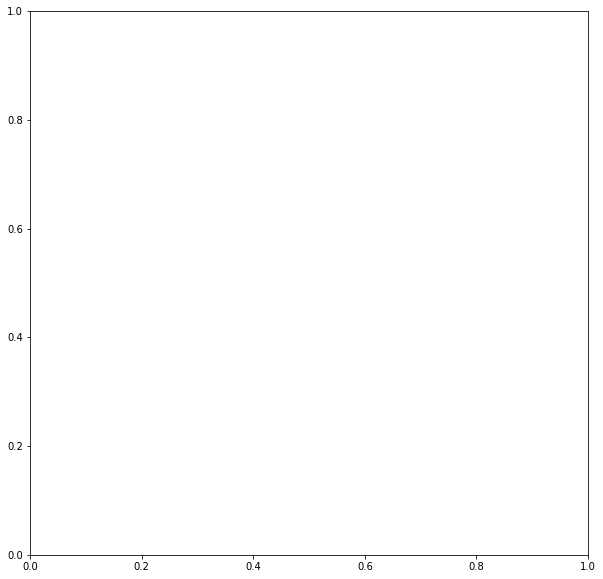

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
idx = 0
for index, em in zip(indices, ems):
    ax.plot(em.index, em.values, 'o-', label= "{:.1f} V_SD".format(voltage[idx]))
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
    idx += 1

Text(0, 0.5, 'log Diffusion constant')

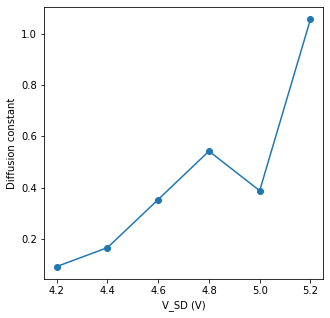

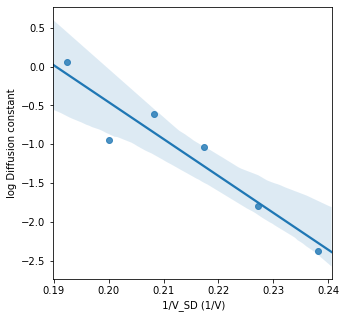

In [120]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(np.arange(2.2,4.3,0.3), D_constants,'o-')
tmpv, D_constants = (list(t) for t in zip(*sorted(zip(voltage, D_constants))))
# tmpp, powers = (list(t) for t in zip(*sorted(zip(voltage, powers))))

ax.plot(np.array(tmpv), D_constants,'o-')
# ax.set_yscale('log')
plt.xlabel('V_SD (V)')
plt.ylabel('Diffusion constant')

fig, ax1 = plt.subplots(figsize=(5,5))
sns.regplot(np.reciprocal(tmpv), np.log(D_constants), 'o-')
# ax.set_yscale('log')
plt.xlabel(' 1/V_SD (1/V)')
plt.ylabel('log Diffusion constant')

# fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(np.arange(-5, -6.49, -0.15),powers,'x-')
# plt.xlabel('V_SD (V)')
# plt.ylabel('power law')

In [117]:
D_constants

[0.0933061317296135,
 0.16699025749690521,
 0.3542195726544141,
 0.5424322925156443,
 0.38859909493084094,
 1.0549939870868301]

The mean square displacement is:  1.01298406047606 nm


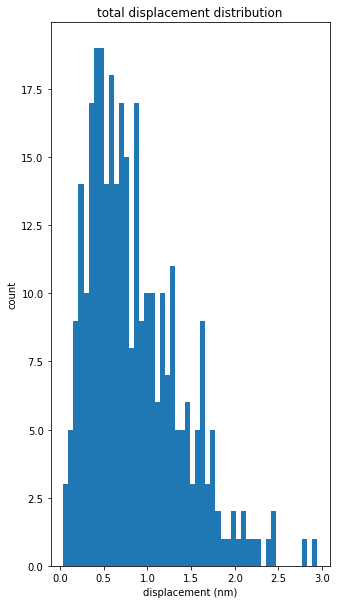

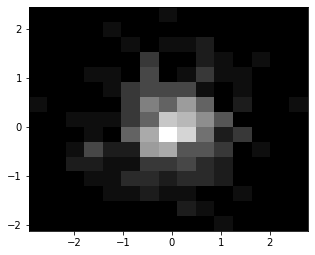

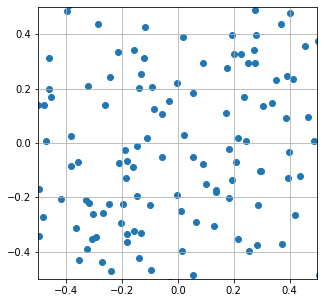

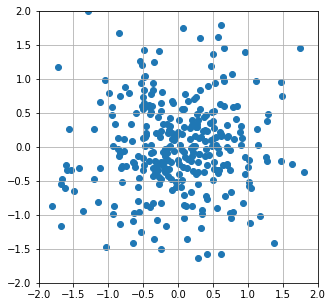

In [118]:
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
ax.set_aspect('equal', 'box')